In [2]:
import sys
sys.path.append('/ossfs/workspace/jd_paper/mydata/')
sys.path.append('/ossfs/workspace/jd_paper/HGT-semi/')
import scipy.io
import urllib.request
import dgl
import math
import numpy as np
import pandas as pd
from model_k import *
import torch
from data_loader import data_loader
from utils.data import load_data
from utils.pytorchtools import EarlyStopping
from utils.tools import evaluate_results_nc
import argparse
import time

def sp_to_spt(mat):
    coo = mat.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape))


def mat2tensor(mat):
    if type(mat) is np.ndarray:
        return torch.from_numpy(mat).type(torch.FloatTensor)
    return sp_to_spt(mat)

def build_heterograph(args):
    if args.device >= 0:
        device = torch.device("cuda:"+str(args.device))
    else:
        device = torch.device('cpu')
    
    print('loading data >>>>>>>>>>>>>>>>>>>>>')
    dataset = data_loader('/ossfs/workspace/jd_paper/mydata/'+args.dataset)
    edge_dict = {}

    for i, meta_path in dataset.links['meta'].items():
        edge_dict[(str(meta_path[0]), str(meta_path[0]) + '_' + str(meta_path[1]), str(meta_path[1]))] = (torch.tensor(dataset.links['data'][i].tocoo().row - dataset.nodes['shift'][meta_path[0]]), torch.tensor(dataset.links['data'][i].tocoo().col - dataset.nodes['shift'][meta_path[1]]))

    node_count = {}
    for i, count in dataset.nodes['count'].items():
        print(i, node_count)
        node_count[str(i)] = count

    print('building dgl.heterograph >>>>>>>>>>>>>>>>>>>>>')
    G = dgl.heterograph(edge_dict, num_nodes_dict = node_count, device=device)
    """
    for ntype in G.ntypes:
        G.nodes[ntype].data['inp'] = dataset.nodes['attr'][ntype]
        # print(G.nodes['attr'][ntype].shape)
    """

    G.node_dict = {}
    G.edge_dict = {}
    for ntype in G.ntypes:
        G.node_dict[ntype] = len(G.node_dict)
    for etype in G.etypes:
        G.edge_dict[etype] = len(G.edge_dict)
        G.edges[etype].data['id'] = torch.ones(G.number_of_edges(etype), dtype=torch.long).to(device) * G.edge_dict[etype] 
#     print('G*****',G)
    return G,dataset

def consis_loss(logps, temp):
    ps = [torch.exp(p) for p in logps]
    sum_p = 0.
    for p in ps:
        sum_p = sum_p + p
    avg_p = sum_p/len(ps)
    #p2 = torch.exp(logp2)
    
    sharp_p = (torch.pow(avg_p, 1./temp) / torch.sum(torch.pow(avg_p, 1./temp), dim=1, keepdim=True)).detach()
    loss = 0.
    for p in ps:
        loss += torch.mean((p-sharp_p).pow(2).sum(1))
    loss = loss/len(ps)
    return args.rate * loss

def run_model_DBLP(args, G, dataset, rep):
    if args.device >= 0:
        device = torch.device("cuda:"+str(args.device))
    else:
        device = torch.device('cpu')
    
    feats_type = args.feats_type
    features_list, adjM, labels, train_val_test_idx, dl = load_data(args.dataset)
    features_list = [mat2tensor(features).to(device) for features in features_list]

    if feats_type == 0:
        in_dims = [features.shape[1] for features in features_list]
    elif feats_type == 1 or feats_type == 5:
        save = 0 if feats_type == 1 else 2
        in_dims = []#[features_list[0].shape[1]] + [10] * (len(features_list) - 1)
        for i in range(0, len(features_list)):
            if i == save:
                in_dims.append(features_list[i].shape[1])
            else:
                in_dims.append(10)
                features_list[i] = torch.zeros((features_list[i].shape[0], 10)).to(device)
    elif feats_type == 2 or feats_type == 4:
        save = feats_type - 2
        in_dims = [features.shape[0] for features in features_list]
        for i in range(0, len(features_list)):
            if i == save:
                in_dims[i] = features_list[i].shape[1]
                continue
            dim = features_list[i].shape[0]
            indices = np.vstack((np.arange(dim), np.arange(dim)))
            indices = torch.LongTensor(indices)
            values = torch.FloatTensor(np.ones(dim))
            features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
    elif feats_type == 3:
        in_dims = [features.shape[0] for features in features_list]
        for i in range(len(features_list)):
            dim = features_list[i].shape[0]
            indices = np.vstack((np.arange(dim), np.arange(dim)))
            indices = torch.LongTensor(indices)
            values = torch.FloatTensor(np.ones(dim))
            features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)

    ## 添加图特征
    for ntype in G.ntypes:
        G.nodes[ntype].data['inp'] = features_list[int(ntype)]#.to(device)
    labels = torch.LongTensor(labels).to(device)
    train_idx = train_val_test_idx['train_idx']
    train_idx = np.sort(train_idx)
    val_idx = train_val_test_idx['val_idx']
    val_idx = np.sort(val_idx)
    test_idx = train_val_test_idx['test_idx']
    test_idx = np.sort(test_idx)
    unlabel_idx = train_val_test_idx['unlabel_idx']
    unlabel_idx = np.sort(unlabel_idx)
    
    ## kk
    is_label = torch.ones(len(G.nodes['0'].data['inp'])).view(-1,1)
    is_label[unlabel_idx]=0
    for ntype in G.ntypes:
        if ntype == '0':
            G.nodes[ntype].data['is_label'] = is_label.to(device)
        else:
            G.nodes[ntype].data['is_label'] = torch.zeros(len(G.nodes[ntype].data['inp'])).view(-1,1).to(device)
    ## kk

    print(len(train_idx), len(test_idx), len(val_idx), len(unlabel_idx))



    model = HGT(G, n_inps=in_dims, n_hid=args.hidden_dim, n_out=labels.max().item()+1, n_layers=args.num_layers, n_heads=args.num_heads, unlabel_idx=unlabel_idx, use_norm = args.use_norm).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=args.weight_decay)#, lr=args.lr, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, total_steps=args.schedule_step, max_lr = 1e-3, pct_start=0.05)

    early_stopping = EarlyStopping(patience=args.patience, verbose=True, save_path='/ossfs/workspace/jd_paper/result/tcheckpoint_consis_{}_{}l_{}th.pt'.format(args.dataset, args.num_layers, rep))
    train_step = 0
    for epoch in range(args.epoch):
        with torch.autograd.set_detect_anomaly(True):
            t_start = time.time()
            model.train()

            label_loss = 0
            unlabel_loss_list = []
            for num_cf in args.num_cf_list:  #[0,5,10,15]
                logits, _ = model(G, '0', num_cf)
                label_loss += F.cross_entropy(logits[train_idx], labels[train_idx].to(device))
                unlabel_loss_list.append(torch.log_softmax(logits[unlabel_idx], dim=-1))
                if num_cf==0:
                    pred = logits.argmax(1)

            unlabel_loss = consis_loss(unlabel_loss_list, temp=args.tem)
            label_loss = label_loss/len(args.num_cf_list)
            print('cross_entropy>>>>>>>> ',label_loss)
            print('consis_loss>>>>>>>> ',unlabel_loss)

            train_loss = label_loss + unlabel_loss
            train_acc = (pred[train_idx] == labels[train_idx]).float().mean()

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            train_step += 1
            scheduler.step(train_step)
            t_end = time.time()
        print('Epoch {:05d} | Train_Loss: {:.4f} | Train_acc: {:.4f} |Time: {:.4f}'.format(epoch, train_loss.item(), train_acc.item(), t_end-t_start))
        t_start = time.time()
        model.eval()
        with torch.no_grad():
            logits, val_embeddings = model(G, '0', 0)
            
            val_loss = F.cross_entropy(logits[val_idx], labels[val_idx])
            pred = logits.cpu().numpy().argmax(axis=1)
        val_acc   = (pred[val_idx] == labels[val_idx].cpu().numpy()).mean()
        test_acc  = (pred[test_idx] == labels[test_idx].cpu().numpy()).mean()
        test_pred_ = pred[test_idx]
        
        
        t_end = time.time()
        print('Epoch {:05d} | Val_Loss {:.4f} | Val_acc {:.4f} | Test_acc {:.4f} | Time(s) {:.4f}'.format(
            epoch, val_loss.item(), val_acc.item(), test_acc.item(), t_end - t_start))
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print('Early stopping!')
            return model,test_idx,dataset,dl 
    return model,test_idx,dataset,dl
  
def inference(args, model, test_idx, dataset, G, rep, dl):
    model.load_state_dict(torch.load('/ossfs/workspace/jd_paper/result/tcheckpoint_consis_{}_{}l_{}th.pt'.format(args.dataset, args.num_layers, rep)))
    model.eval()

    with torch.no_grad():
        logits, test_embeddings = model(G, '0', 0)
        test_logits = logits[test_idx]
        
        if args.dataset == 'IMDB1':
            pred = test_logits.cpu().numpy()
        else:
            pred = test_logits.cpu().numpy().argmax(axis=1)
        
        onehot = np.eye(dataset.labels_train['num_classes'], dtype=np.int32)
        pred = onehot[pred]
                
        eval_res = dataset.evaluate(pred)
        print(eval_res['micro-f1'], eval_res['macro-f1'])
        
        svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = evaluate_results_nc(
                test_embeddings[test_idx].cpu().numpy(), dataset.labels_test['data'][dataset.labels_test['mask']].argmax(axis=1), num_classes=dataset.labels_test['num_classes'])

        return eval_res,svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std

In [3]:

# if __name__ == '__main__':
ap = argparse.ArgumentParser(description='MRGNN testing for the DBLP dataset')
ap.add_argument('--feats-type', type=int, default=0,
                help='Type of the node features used. ' +
                        '0 - loaded features; ' +
                        '1 - only target node features (zero vec for others); ' +
                        '2 - only target node features (id vec for others); ' +
                        '3 - all id vec. Default is 2;' +
                    '4 - only term features (id vec for others);' + 
                    '5 - only term features (zero vec for others).')
ap.add_argument('--hidden_dim', type=int, default=64, help='Dimension of the node hidden state. Default is 64.')
ap.add_argument('--num_heads', type=int, default=8, help='Number of the attention heads. Default is 8.')
ap.add_argument('--epoch', type=int, default=300, help='Number of epochs.')
ap.add_argument('--patience', type=int, default=30, help='Patience.')
ap.add_argument('--repeat', type=int, default=5, help='Repeat the training and testing for N times. Default is 1.')
ap.add_argument('--num_layers', type=int, default=15) #5
ap.add_argument('--lr', type=float, default=1e-2) #5e-3
ap.add_argument('--dropout', type=float, default=0)
ap.add_argument('--weight-decay', type=float, default=1e-3) #1e-4
ap.add_argument('--slope', type=float, default=0.05)
ap.add_argument('--dataset', type=str, default='JD2')  #  ACM
ap.add_argument('--edge-feats', type=int, default=64)
ap.add_argument('--device', type=int, default=0)
ap.add_argument('--schedule_step', type=int, default=300)
ap.add_argument('--use_norm', type=bool, default=True)
ap.add_argument('--rate', type=float, default=0.2)
ap.add_argument('--num_cf_list', type=list, default=[0,5,10,15]) #[0,5,10,15]
ap.add_argument('--tem', type=float, default=0.2)

args = ap.parse_args(args=[])
g, dataset = build_heterograph(args)

# 4种类型的节点统一编号
# labels_test1 = pd.read_csv("../data/"+args.dataset+"/label.dat.test", sep = "\t", header=None,
#                  names=["node_id","node_name","node_type","label"])

micro,macro = [],[]
svm_macro_f1_lists,svm_micro_f1_lists,nmi_mean_list,nmi_std_list,ari_mean_list,ari_std_list = [],[],[],[],[],[]
for r in range(args.repeat):
    print('running the '+str(r)+' times >>>>>>>>>>>>')
#     model,test_idx,dataset,dl = run_model_DBLP(args, g, dataset, r, labels_test1)
    model,test_idx,dataset,dl = run_model_DBLP(args, g, dataset, r)
    eval_res,svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = inference(args, model, test_idx, dataset, g, r, dl)
    macro.append(eval_res['macro-f1'])
    micro.append(eval_res['micro-f1'])
    svm_macro_f1_lists.append(svm_macro_f1_list)
    svm_micro_f1_lists.append(svm_micro_f1_list)
    nmi_mean_list.append(nmi_mean)
    nmi_std_list.append(nmi_std)
    ari_mean_list.append(ari_mean)
    ari_std_list.append(ari_std)

    
m_macro = np.mean(macro)
std_macro = np.std(macro)
m_micro = np.mean(micro)
std_micro = np.std(micro)
sqrt_n = np.sqrt(len(micro))
print('------------------------------ final result ----------------------------------------')
print('final result macro_f1 >>>>>>>>>> ',m_macro,'+-',1.96*std_macro/sqrt_n)
print('final result micro_f1 >>>>>>>>>> ',m_micro,'+-',1.96*std_micro/sqrt_n)

# print out a summary of the evaluations
svm_macro_f1_lists = np.transpose(np.array(svm_macro_f1_lists), (1, 0, 2))
svm_micro_f1_lists = np.transpose(np.array(svm_micro_f1_lists), (1, 0, 2))
nmi_mean_list = np.array(nmi_mean_list)
nmi_std_list = np.array(nmi_std_list)
ari_mean_list = np.array(ari_mean_list)
ari_std_list = np.array(ari_std_list)
print('----------------------------------------------------------------')
print('SVM tests summary')
print('Macro-F1: ' + ', '.join(['{:.6f}~{:.6f} ({:.1f})'.format(
    macro_f1[:, 0].mean(), macro_f1[:, 1].mean(), train_size) for macro_f1, train_size in
    zip(svm_macro_f1_lists, [0.8, 0.6, 0.4, 0.2])]))
print('Micro-F1: ' + ', '.join(['{:.6f}~{:.6f} ({:.1f})'.format(
    micro_f1[:, 0].mean(), micro_f1[:, 1].mean(), train_size) for micro_f1, train_size in
    zip(svm_micro_f1_lists, [0.8, 0.6, 0.4, 0.2])]))
print('K-means tests summary')
print('NMI: {:.6f}~{:.6f}'.format(nmi_mean_list.mean(), nmi_std_list.mean()))
print('ARI: {:.6f}~{:.6f}'.format(ari_mean_list.mean(), ari_std_list.mean()))


loading data >>>>>>>>>>>>>>>>>>>>>
0 {}
1 {'0': 10000}
building dgl.heterograph >>>>>>>>>>>>>>>>>>>>>
running the 0 times >>>>>>>>>>>>
2400 7000 600 7000


/ossfs/workspace/jd_paper/HGT-semi/model_k.py:98: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  unlabel_idx = (is_label == 0).nonzero()[:,0]


cross_entropy>>>>>>>>  tensor(0.7736, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0331, device='cuda:0', grad_fn=<MulBackward0>)


/root/miniconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 00000 | Train_Loss: 0.8068 | Train_acc: 0.5263 |Time: 18.9223
Epoch 00000 | Val_Loss 0.7554 | Val_acc 0.4933 | Test_acc 0.5167 | Time(s) 0.8281
Validation loss decreased (inf --> 0.755394).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7671, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0335, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00001 | Train_Loss: 0.8005 | Train_acc: 0.5292 |Time: 17.7199
Epoch 00001 | Val_Loss 0.7551 | Val_acc 0.4950 | Test_acc 0.5206 | Time(s) 0.7910
Validation loss decreased (0.755394 --> 0.755103).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7551, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0335, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00002 | Train_Loss: 0.7886 | Train_acc: 0.5462 |Time: 17.9433
Epoch 00002 | Val_Loss 0.7550 | Val_acc 0.5100 | Test_acc 0.5280 | Time(s) 0.9877
Validation loss decreased (0.755103 --> 0.754961).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7676

/root/miniconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 00000 | Train_Loss: 0.7909 | Train_acc: 0.5250 |Time: 17.6917
Epoch 00000 | Val_Loss 0.7247 | Val_acc 0.5167 | Test_acc 0.5406 | Time(s) 0.8346
Validation loss decreased (inf --> 0.724714).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7533, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0348, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00001 | Train_Loss: 0.7881 | Train_acc: 0.5492 |Time: 18.0778
Epoch 00001 | Val_Loss 0.7236 | Val_acc 0.5200 | Test_acc 0.5429 | Time(s) 0.8944
Validation loss decreased (0.724714 --> 0.723593).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7560, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0349, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00002 | Train_Loss: 0.7909 | Train_acc: 0.5513 |Time: 18.2031
Epoch 00002 | Val_Loss 0.7219 | Val_acc 0.5250 | Test_acc 0.5474 | Time(s) 0.8395
Validation loss decreased (0.723593 --> 0.721943).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7446

/root/miniconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 00000 | Train_Loss: 0.7973 | Train_acc: 0.4875 |Time: 17.9333
Epoch 00000 | Val_Loss 0.6918 | Val_acc 0.5483 | Test_acc 0.5681 | Time(s) 0.9065
Validation loss decreased (inf --> 0.691819).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7741, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0269, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00001 | Train_Loss: 0.8010 | Train_acc: 0.4850 |Time: 17.7091
Epoch 00001 | Val_Loss 0.6902 | Val_acc 0.5533 | Test_acc 0.5726 | Time(s) 0.8513
Validation loss decreased (0.691819 --> 0.690176).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7690, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0265, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00002 | Train_Loss: 0.7955 | Train_acc: 0.4888 |Time: 18.0748
Epoch 00002 | Val_Loss 0.6880 | Val_acc 0.5583 | Test_acc 0.5824 | Time(s) 0.8581
Validation loss decreased (0.690176 --> 0.687963).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7745

/root/miniconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 00000 | Train_Loss: 0.7960 | Train_acc: 0.5213 |Time: 17.4565
Epoch 00000 | Val_Loss 0.6816 | Val_acc 0.5667 | Test_acc 0.5584 | Time(s) 0.7946
Validation loss decreased (inf --> 0.681638).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7635, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0308, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00001 | Train_Loss: 0.7943 | Train_acc: 0.5075 |Time: 17.5956
Epoch 00001 | Val_Loss 0.6787 | Val_acc 0.5750 | Test_acc 0.5624 | Time(s) 0.8408
Validation loss decreased (0.681638 --> 0.678680).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7637, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0306, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00002 | Train_Loss: 0.7944 | Train_acc: 0.5221 |Time: 18.4157
Epoch 00002 | Val_Loss 0.6745 | Val_acc 0.5850 | Test_acc 0.5716 | Time(s) 0.7997
Validation loss decreased (0.678680 --> 0.674548).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.7650

/root/miniconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 00000 | Train_Loss: 0.8396 | Train_acc: 0.5025 |Time: 18.0224
Epoch 00000 | Val_Loss 0.8942 | Val_acc 0.4383 | Test_acc 0.4320 | Time(s) 0.7877
Validation loss decreased (inf --> 0.894159).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.8157, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0330, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00001 | Train_Loss: 0.8487 | Train_acc: 0.4892 |Time: 17.5990
Epoch 00001 | Val_Loss 0.8857 | Val_acc 0.4433 | Test_acc 0.4343 | Time(s) 0.7981
Validation loss decreased (0.894159 --> 0.885672).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.8098, device='cuda:0', grad_fn=<DivBackward0>)
consis_loss>>>>>>>>  tensor(0.0328, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00002 | Train_Loss: 0.8427 | Train_acc: 0.4900 |Time: 17.8067
Epoch 00002 | Val_Loss 0.8725 | Val_acc 0.4467 | Test_acc 0.4394 | Time(s) 0.7950
Validation loss decreased (0.885672 --> 0.872479).  Saving model ...
cross_entropy>>>>>>>>  tensor(0.8167

In [ ]:

import pandas as pd
from data_loader import gen_file_for_evaluate
data = 'DBLP'

for i in range(5):
    df = pd.read_csv('../result/'+data+'_'+str(i)+'.txt', sep='\t', names=["node_id","node_name","node_type","label"])
    df[['label']].to_csv('../result1/'+data+'_'+str(i)+'.txt', sep='\t',index=False, header = False)

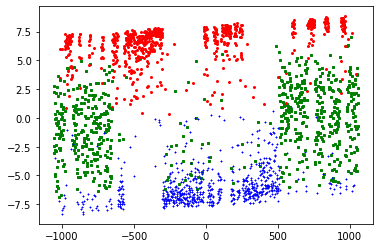

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('../SemiData/kmeans_res_ACM.csv')

emb = data.drop(['y_pred'],axis=1)
y_pred = data['y_pred'].values

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# pca = PCA(n_components=2)
# pca.fit(emb)
# X_new = pca.transform(emb)

tsne = TSNE(n_components=2)
tsne.fit(emb)
X_new = tsne.transform(emb)

mark=['or','+b','sg','dk','py']
j=0
for i in y_pred:
    plt.plot(X_new[j:j+1,0],X_new[j:j+1,1],mark[i],markersize=2)
    j += 1
plt.show()

In [ ]:
1

In [11]:
def reOrderArrayTwo(array):
        # write code here
        if not array:
            return array
        res = []
        i,j = 0,len(array)-1
        while i<j:
            print(array[i],array[j])
            if array[i]%2==0 and array[j]%2:
                array[i],array[j] = array[j],array[i]
                i += 1
                j -= 1
            while array[i]%2==0:
                j -= 1
            if array[j]%2:
                i += 1
        return array

In [13]:
len([])

0

In [ ]:
p1 = ph.next
sol = Solution()
sol.deleteDuplication(p1)

******:  1
>>>>  1
1
8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>>>>  8
>

In [11]:
ph = ListNode(0)
ph.val

0